# 2019년 10월 이커머스 데이터 EDA

In [ ]:
# pip install plotly==5.8.0

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.parser import parse
import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# org_df = pd.read_csv("D:/cp2_dataset/2019-Oct.csv")
# df = org_df.copy()

In [ ]:
# csv -> parquet 파일로 변환
# df.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [ ]:
# parquet 파일 읽기
# df = pd.read_parquet('D:/cp2_dataset/df.parquet', engine='pyarrow')

## event_time 컬럼 나누기

In [ ]:
# # event_time 컬럼 타입 str -> datetime64로 변경
# df["event_time"] = pd.to_datetime(df["event_time"])

In [ ]:
# df["event_time"]

In [ ]:
# # event_time 열 timezone UTC -> Asia/Dubai로 변경 (GMT +4)
# df["event_time"] = df["event_time"].apply(lambda x : x.tz_convert("Asia/Dubai"))

In [ ]:
# df["event_time"]

In [ ]:
# # event_time 월, 일, 요일, 시 빼내기
# df["month"] = df["event_time"].dt.month
# df["day"] = df["event_time"].dt.day
# df["day_name"] = df["event_time"].apply(lambda x : x.day_name())
# df["hour"] = df["event_time"].dt.hour

In [ ]:
# df.shape

In [ ]:
# df.columns

In [ ]:
# column_order = ['event_time', 'month', 'day', 'day_name', 'hour', 
#                 'event_type', 'product_id', 'category_id', 'category_code', 
#                 'brand', 'price', 'user_id', 'user_session']
# df_mod = df[column_order]

In [ ]:
# df_mod.head()

## parquet 파일 저장 후 작업 개시

In [ ]:
# # event_time 컬럼 변경한 것 parquet 파일로 저장
# df_mod.to_parquet("D:/cp2_dataset/df.parquet", engine="pyarrow", compression="gzip")

In [ ]:
# pip install datawig

In [ ]:
# pip install pyarrow

In [2]:
# parquet_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/df.parquet"
parquet_path = "D:/cp2_dataset/df.parquet"

In [3]:
mod = pd.read_parquet(parquet_path, engine='pyarrow')

In [4]:
mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [ ]:
mod["event_type"].value_counts(normalize=True)

view        0.960673
cart        0.021827
purchase    0.017500
Name: event_type, dtype: float64

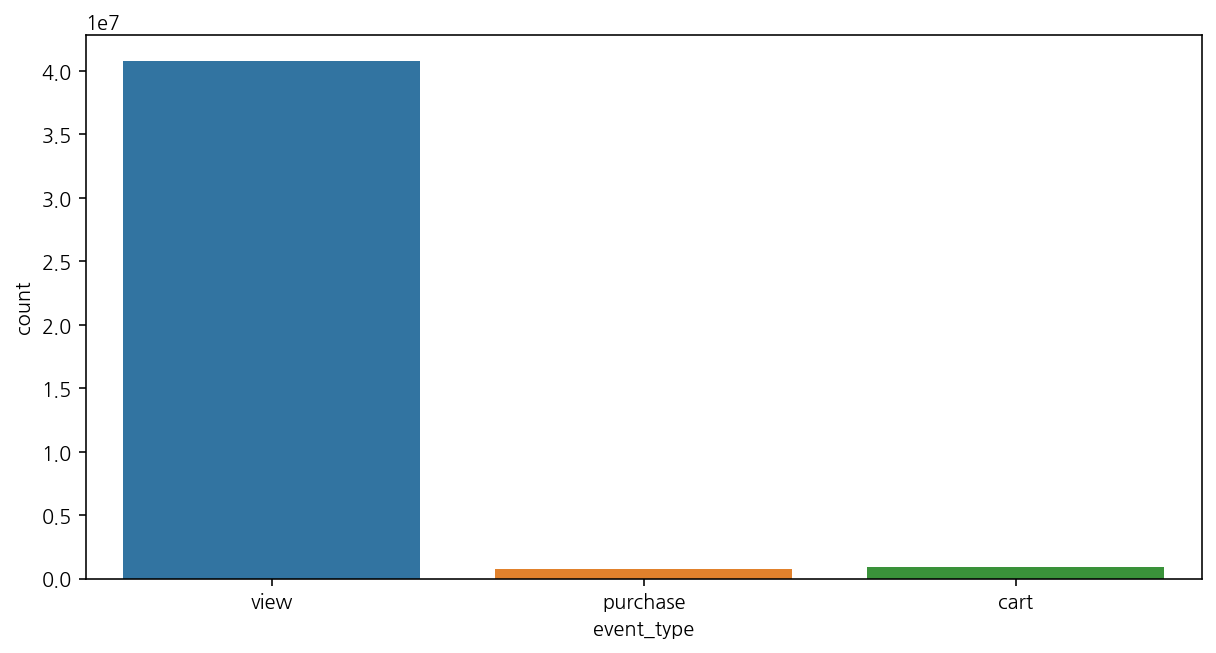

In [ ]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=mod["event_type"])
plt.show()

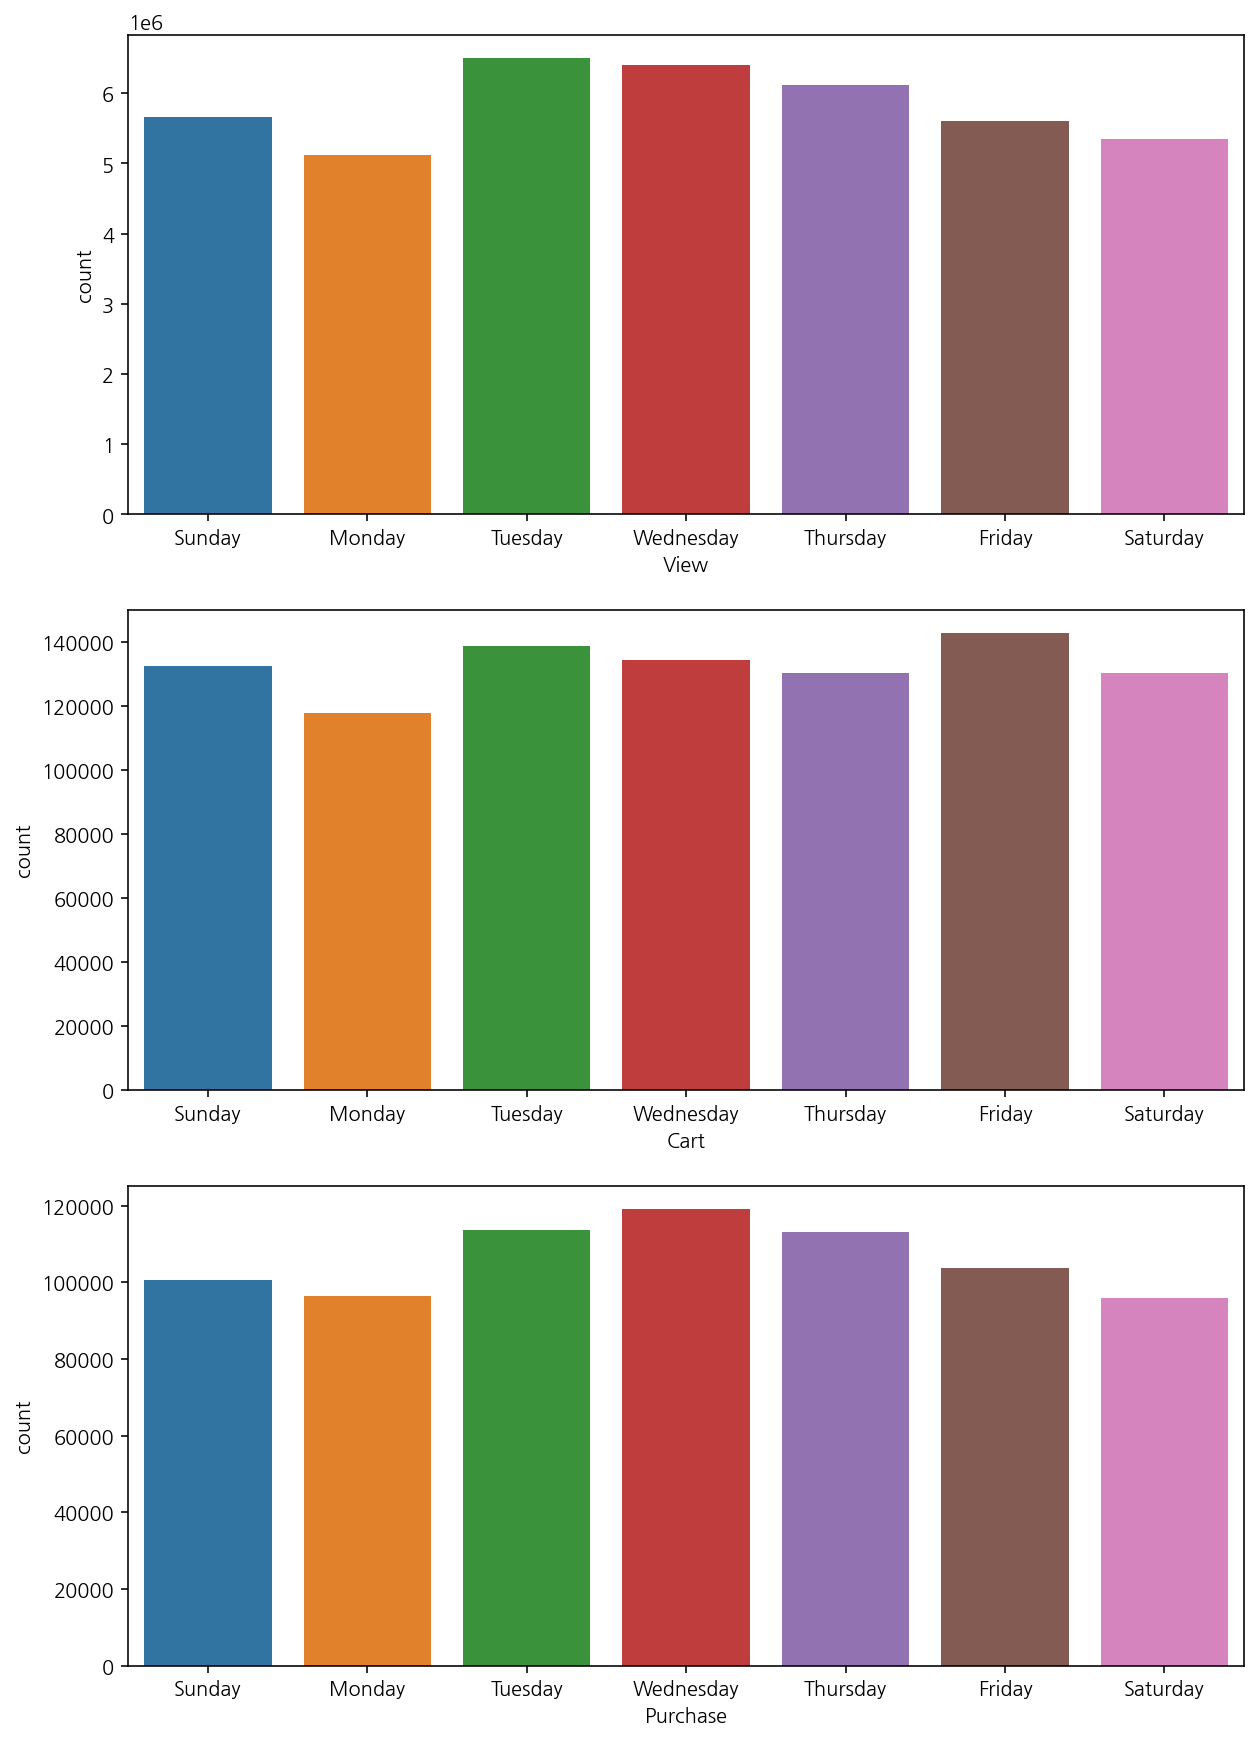

In [ ]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (mod["event_type"] == "view")
cart_cond = (mod["event_type"] == "cart")
purchase_cond = (mod["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=mod[view_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],              ax=ax[0])
view_cnt.set_xlabel("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=mod[cart_cond]["day_name"],
                         order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                         ax=ax[1])
cart_cnt.set_xlabel("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=mod[purchase_cond]["day_name"],
                             order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                             ax=ax[2])
purchase_cnt.set_xlabel("Purchase")

plt.show()

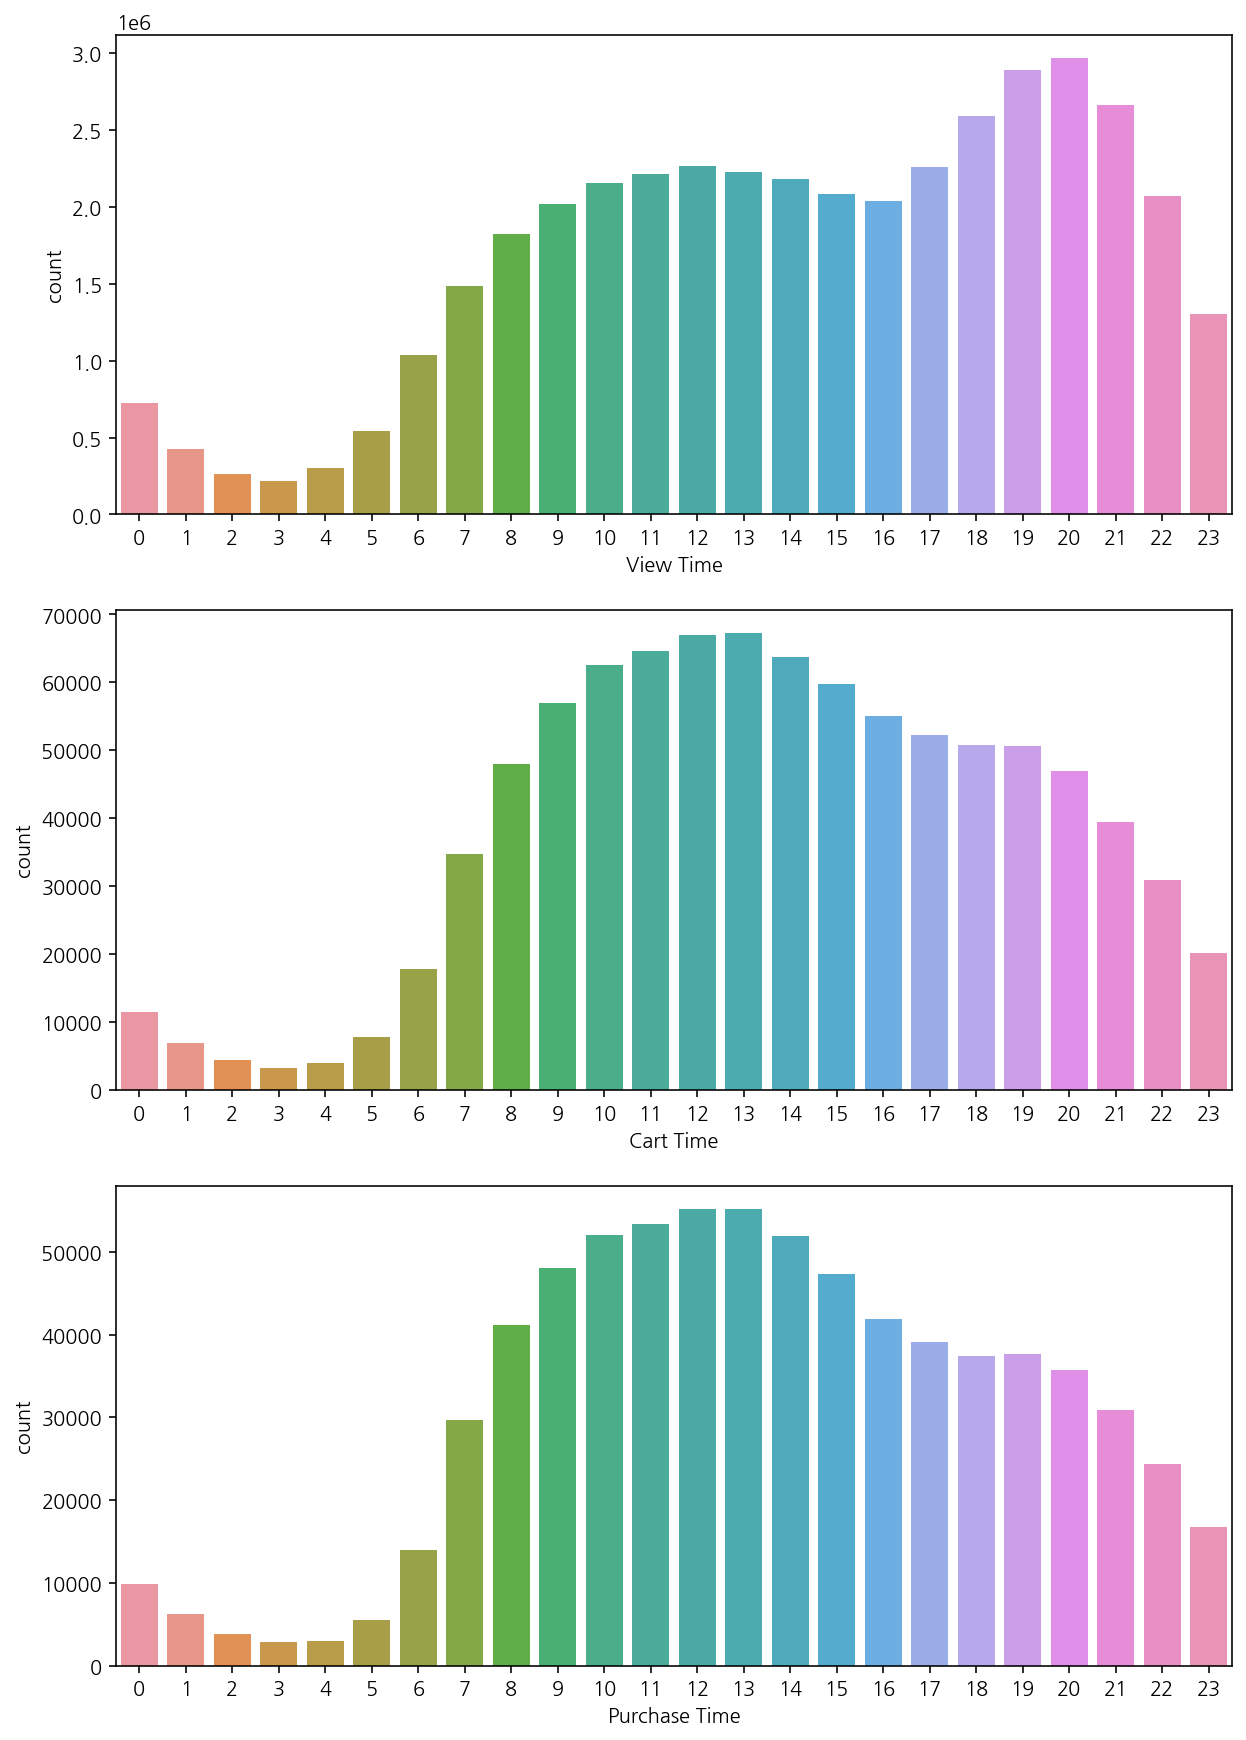

In [ ]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=mod[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_xlabel("View Time")

# 요일별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=mod[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_xlabel("Cart Time")

# 요일별 구매한 숫자
purchase_time_cnt = sns.countplot(x=mod[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_xlabel("Purchase Time")

plt.show()

## category_code TOP 10 분석

In [ ]:
# 카테고리 코드 TOP 10
mod["category_code"].value_counts()[:10]

electronics.smartphone              11507231
electronics.clocks                   1311033
computers.notebook                   1137623
electronics.video.tv                 1113750
electronics.audio.headphone          1100188
appliances.kitchen.refrigerators      887755
appliances.kitchen.washer             869404
appliances.environment.vacuum         801670
apparel.shoes                         763901
auto.accessories.player               470208
Name: category_code, dtype: int64

In [ ]:
# 대분류 TOP 10
main_cat = mod["category_code"].str.split(".").str[0].value_counts()[:10]
main_cat

electronics     16135623
appliances       4967294
computers        2324217
apparel          1542924
furniture        1247160
auto             1013115
construction      730834
kids              520619
accessories       238238
sport             176616
Name: category_code, dtype: int64

In [ ]:
# 중분류 TOP 10
sub_cat_1st = mod["category_code"].str.split(".").str[1].value_counts()[:10]
sub_cat_1st

smartphone     11507231
kitchen         3531445
audio           1574674
clocks          1311033
shoes           1208383
environment     1147634
notebook        1137623
video           1126904
accessories     1013115
tools            719816
Name: category_code, dtype: int64

In [ ]:
# 소분류 TOP 10
sub_cat_2nd = mod["category_code"].str.split(".").str[2].value_counts()[:10]
sub_cat_2nd

tv               1113750
headphone        1100188
refrigerators     887755
washer            869404
vacuum            801670
player            470208
keds              410304
bed               358453
subwoofer         313664
cabinet           301410
Name: category_code, dtype: int64

In [ ]:
# 브랜드 TOP 10
brand_top10 = mod["brand"].value_counts()[:10]
brand_top10

samsung    5282775
apple      4122554
xiaomi     3083763
huawei     1111205
lucente     655861
lg          562404
bosch       557090
oppo        482887
sony        456644
acer        428153
Name: brand, dtype: int64

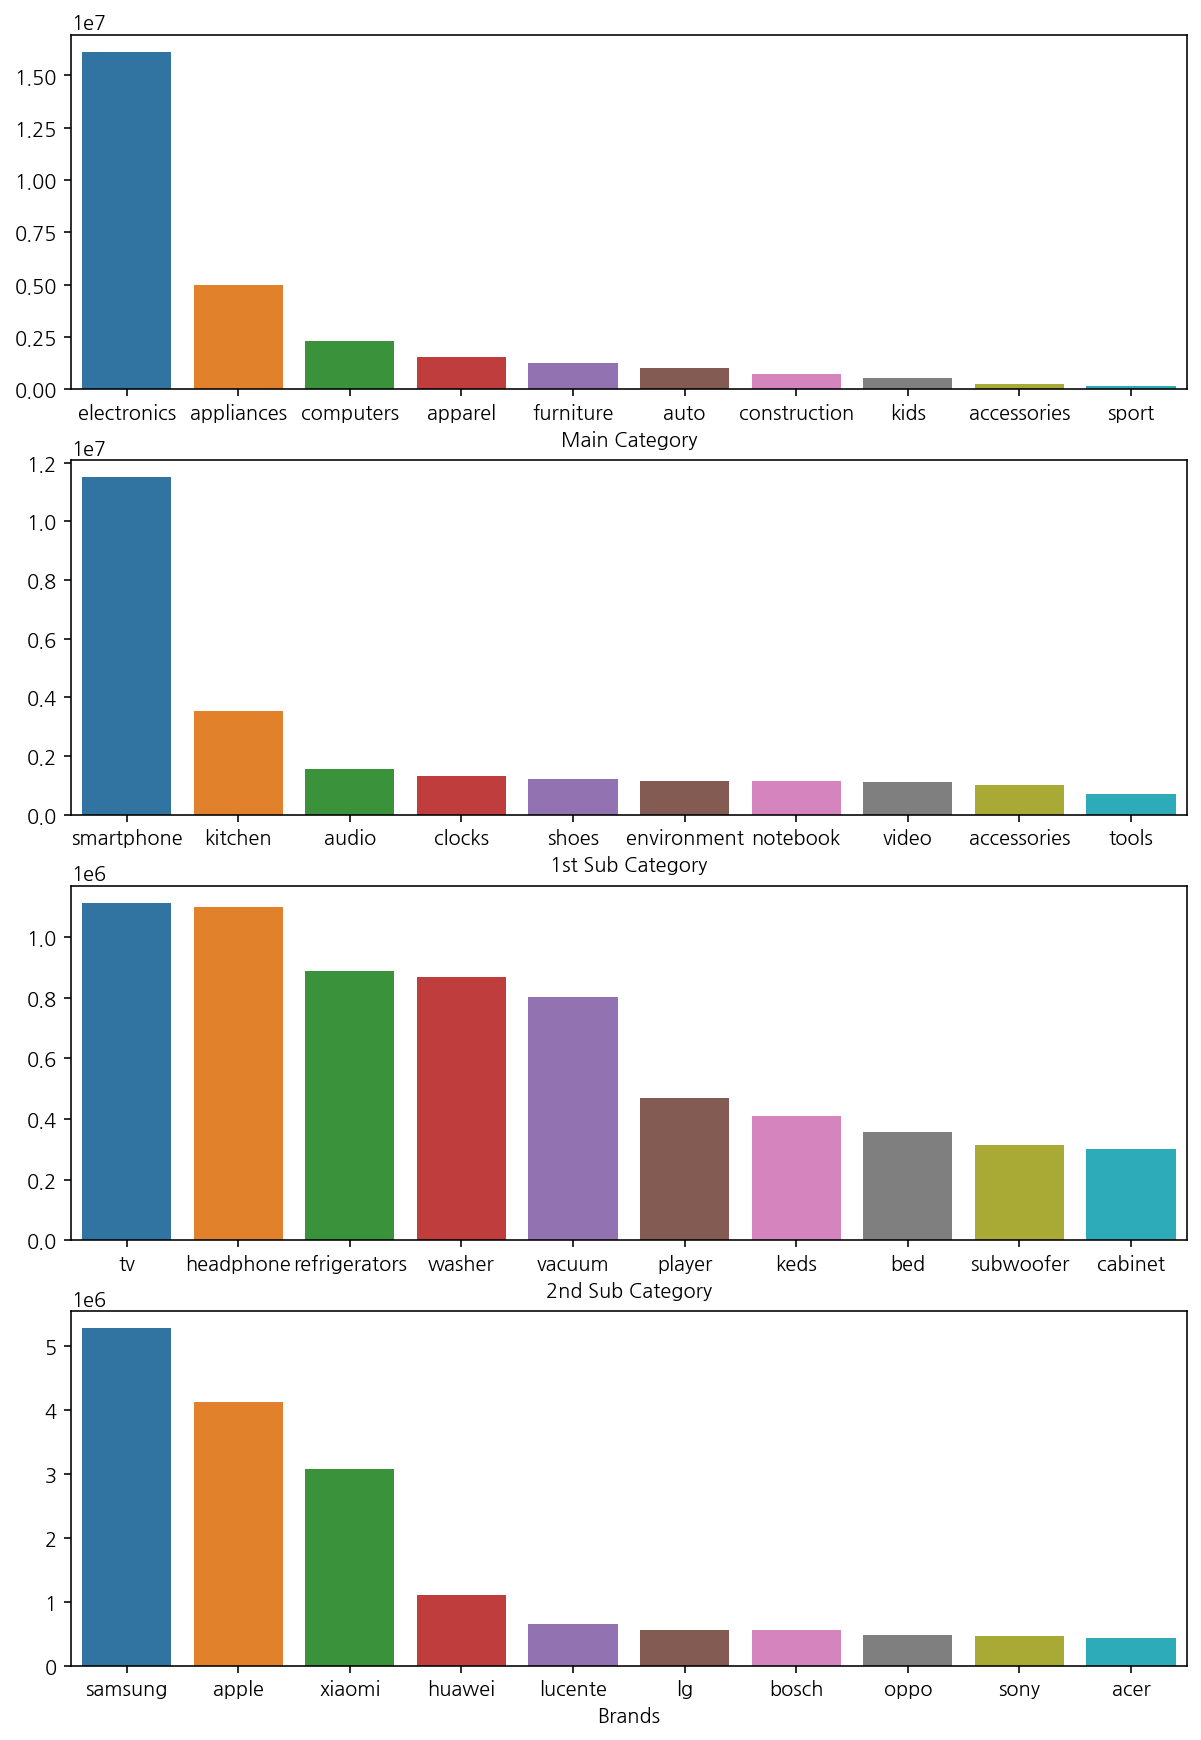

In [ ]:
# 카테고리별 TOP 10 (대분류, 중분류, 소분류), 브랜드 TOP 10

# 조건별로 plot 생성
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# 메인 카테고리 (대분류) Top 10
main_bar = sns.barplot(x=main_cat.index, 
                       y=main_cat.values,
                       ax=ax[0])
main_bar.set_xlabel("Main Category")

# 중분류 Top 10
sub_1st_bar = sns.barplot(x=sub_cat_1st.index,
                          y=sub_cat_1st.values,
                          ax=ax[1])
sub_1st_bar.set_xlabel("1st Sub Category")

# 소분류 Top 10
sub_2nd_bar = sns.barplot(x=sub_cat_2nd.index,
                          y=sub_cat_2nd.values,
                          ax=ax[2])
sub_2nd_bar.set_xlabel("2nd Sub Category")

# 브랜드 Top 10
brand_bar = sns.barplot(x=brand_top10.index,
                        y=brand_top10.values,
                        ax=ax[3])
brand_bar.set_xlabel("Brands")

plt.show()

## 구매 히트맵

### 

## 결측치 확인 및 처리

In [ ]:
mod.shape

(42448764, 13)

In [23]:
mod.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [136]:
def null_list(df, col, idx_num=15):
    
    na_cond = df["category_code"].isnull()                  # category_code가 NaN인 것 조건 설정
    null_cat = df[na_cond][f"{col}"].value_counts()         # 위의 조건 적용한 것 중, 컬럼 이름 col인 것 value_counts()
    null_cat_values = null_cat[idx_num:(idx_num+15)]        # value_counts()한 것들 15개 추려냄
    null_cat_list = null_cat_values.keys().tolist()         # 추려낸 15개 list 생성

    # 빈 데이터프레임 생성
    df_2 = pd.DataFrame()

    # null_cat_list에 있는 category_id로 for문 생성하여 product_id 탐색
    for cat_id in null_cat_list:
        cat_id_cond = (df["category_id"] == cat_id)
        # category_id로 검색한 것의 product_id 숫자 많은 것 중 중복안된 5개 prod_id list로 설정
        prod_id = df[cat_id_cond]["product_id"].value_counts().head(5).keys().tolist()
        value_count = df[cat_id_cond]["product_id"].value_counts().head(5).tolist()
        # 앞서 생성한 빈 데이터프레임에 category_id와 prod_id 채워넣음
        df_2 = df_2.append(pd.DataFrame(
            [[cat_id, prod_id, value_count]], columns=["category_id", "product_id", "value_count"])).reset_index(drop=True)
    return df_2

In [137]:
null_list(mod, "category_id")

,category_id,product_id,value_count
0,2062461754293617058,"[34800270, 34800104, 34800089, 34800250, 34800...","[9928, 4612, 4341, 3631, 3141]"
1,2053013552259662037,"[8500088, 8500086, 8500461, 8500140, 8500459]","[5351, 5235, 5045, 4286, 3812]"
2,2053013563550729061,"[26500135, 26500313, 26500144, 26500134, 26500...","[7118, 6257, 5615, 5374, 4066]"
3,2053013558525952589,"[18000919, 18001068, 18001292, 18001338, 18000...","[4228, 2960, 2312, 2287, 2097]"
4,2053013558031024687,"[31500231, 31501046, 31500157, 31501167, 31501...","[12253, 8366, 6815, 4481, 3910]"
5,2053013553484398879,"[15200519, 15200181, 15200784, 15200781, 15200...","[6375, 5676, 3501, 3193, 2143]"
6,2053013554994348409,"[10800172, 10800025, 10800132, 10800128, 10800...","[10250, 9246, 4717, 4400, 4330]"
7,2053013555355058573,"[3300349, 3300315, 3300495, 3300010, 3300317]","[16392, 8209, 8121, 4910, 3652]"
8,2053013557166998015,"[13300108, 13300159, 13300090, 13300551, 13300...","[6841, 6564, 5439, 4102, 3911]"
9,2085718636156158307,"[38900019, 38900028, 38900027, 38900026, 38900...","[18570, 6867, 6529, 6248, 5950]"


16) 2062461754293617058 : 카시트
    - auto -> car accessories -> covers for salon
17) 2053013552259662037 : 보일러
    - appliances -> air conditioning equipment -> heating boilers
18) 2053013563550729061 : 팔찌
    - accessories -> jewelry -> bracelets
19) 2053013558525952589 : 핸드폰 케이스
    - phones and gadgets -> phone accessories -> smartphone cases
20) 2053013558031024687 : 찻잔세트
    - goods for home and garden -> crockery and accessories -> table setting -> services
21) 2053013553484398879 : 자동차 배터리
    - auto -> batteries
22) 2053013554994348409 : 멀티베이커
    - appliances -> small kitchen appliances -> dessert technology -> multibakers
23) 2053013555355058573 : 멀티쿠커(밥솥)
    - appliances -> small kitchen appliances -> dessert technology -> multicookers
24) 2053013557166998015 : 매트리스 (swisshome)
    - furniture -> bedroom -> mattresses
25) 2085718636156158307 : 베개 (evim)
    - goods for home and garden -> home textiles -> pillows and pillowcases -> pillows
26) 2053013558190408249 : 후라이팬
    - goods for home and garden -> crockery and accessories -> utensils for cooking -> frying pans
27) 2053013555287949705 : 푸드 프로세서
    - appliances -> small kitchen appliances -> food processors and meat grinders -> food processor
28) 2144356630513320518 : 모피 코트
    - clothing -> women -> women's outerwear -> women's coats and fur vests
29) 2053013560144954031 : 고압세척기 (electric sink)
    - goods for home and garden -> cottage, garden and vegetable garden -> garden equipment -> High pressure washers
30) 2053013554524586339 : 오디오
    - tv, audio, video -> audio equipment -> music centers

16) 2062461754293617058 : 카시트
    - "auto.accessories.car_seat" (신규 생성)
17) 2053013552259662037 : 보일러
    - "appliances.environment.boiler" (신규 생성)
18) 2053013563550729061 : 팔찌
    - "accessories.jewelry" (신규 생성)
19) 2053013558525952589 : 핸드폰 케이스
    - 'electronics.smartphone.phone_accessories' (신규 생성)
20) 2053013558031024687 : 찻잔세트
    - "furniture.kitchen.crockery" (신규 생성)
21) 2053013553484398879 : 자동차 배터리
    - "auto.accessories.battery" (신규 생성)
22) 2053013554994348409 : 멀티베이커
    - "appliances.kitchen.multibaker" (신규 생성)
23) 2053013555355058573 : 멀티쿠커(밥솥)
    - "appliances.kitchen.multicooker" (신규 생성)
24) 2053013557166998015 : 매트리스 (swisshome)
    - "furniture.bedroom.mattress" (신규 생성)
25) 2085718636156158307 : 베개 (evim)
    - 'furniture.bedroom.pillow'
26) 2053013558190408249 : 후라이팬
    - "furniture.kitchen.pan" (신규 생성)
27) 2053013555287949705 : 푸드 프로세서
    - "appliances.kitchen.meat_grinder"
28) 2144356630513320518 : 모피 코트
    - "apparel.coat" (신규 생성)
29) 2053013560144954031 : 고압세척기 (electric sink)
    - "appliances.kitchen.washer"
30) 2053013554524586339 : 오디오
    - 'electronics.audio.music_center'

In [4]:
category_dict = {2053013553559896355 : 'auto.accessories.tire',
                 2053013563651392361 : 'accessories.jewelry',
                 2053013556168753601 : 'construction.tool.kit',
                 2053013563693335403 : 'accessories.jewelry',
                 2053013557024391671 : 'furniture.bedroom.set',
                 2053013563970159485 : 'appliances.kitchen.cooker',
                 2053013563173241677 : 'beauty.technique.dryer',
                 2053013553853497655 : 'beauty.perfumery',
                 2053013553375346967 : 'electronics.clock',
                 2053013563584283495 : 'accessories.jewelry',
                 2053013553526341921 : 'auto.accessories.disc',
                 2053013559733912211 : 'furniture.living_room',
                 2053013564918072245 : 'home.textiles.carpet',
                 2053013561218695907 : 'electronics.video.tv',
                 2053013552385491165 : 'appliances.environment.air_conditioning',
                 2062461754293617058 : 'auto.accessories.car_seat',
                 2053013552259662037 : 'appliances.environment.boiler',
                 2053013563550729061 : 'accessories.jewelry',
                 2053013558525952589 : 'electronics.smartphone.phone_accessories',
                 2053013558031024687 : 'furniture.kitchen.crockery',
                 2053013553484398879 : 'auto.accessories.battery',
                 2053013554994348409 : 'appliances.kitchen.multibaker',
                 2053013555355058573 : 'appliances.kitchen.multicooker',
                 2053013557166998015 : 'furniture.bedroom.mattress',
                 2085718636156158307 : 'furniture.bedroom.pillow',
                 2053013558190408249 : 'furniture.kitchen.pan',
                 2053013555287949705 : 'appliances.kitchen.meat_grinder',
                 2144356630513320518 : 'apparel.coat',
                 2053013560144954031 : 'appliances.kitchen.washer',
                 2053013554524586339 : 'electronics.audio.music_center'
                }

In [5]:
df_mod = mod.copy()

In [6]:
df_mod["category_code"].isnull().sum()

13515609

In [7]:
def fill_cat(df, col="category_code"):
    nones = df[col].isnull()
    for cat_id, cat_code in category_dict.items():
        # category_id 열이 cat_id와 동일
        cat_cond = (df["category_id"] == cat_id)

        df.loc[nones & cat_cond, col] = cat_code

    return df

In [8]:
fill_cat(df_mod)

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,44600062,2103807459595387724,None,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 04:00:00+04:00,10,1,Tuesday,4,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,17200506,2053013559792632471,furniture.living_room.sofa,None,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 04:00:01+04:00,10,1,Tuesday,4,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 04:00:04+04:00,10,1,Tuesday,4,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42448759,2019-11-01 03:59:58+04:00,11,1,Friday,3,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
42448760,2019-11-01 03:59:58+04:00,11,1,Friday,3,view,10800172,2053013554994348409,appliances.kitchen.multibaker,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
42448761,2019-11-01 03:59:58+04:00,11,1,Friday,3,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
42448762,2019-11-01 03:59:59+04:00,11,1,Friday,3,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204


In [12]:
mod.isnull().sum()

event_time              0
month                   0
day                     0
day_name                0
hour                    0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [9]:
fill_cat(df_mod).isnull().sum()

event_time             0
month                  0
day                    0
day_name               0
hour                   0
event_type             0
product_id             0
category_id            0
category_code    4707919
brand            6117080
price                  0
user_id                0
user_session           2
dtype: int64

In [10]:
mod.isnull().sum()

event_time              0
month                   0
day                     0
day_name                0
hour                    0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [15]:
4707919 / df_mod.shape[0]

0.11090827049758151

In [212]:
str_cond = mod["category_code"].str.contains("kitchen", na=False)
mod[str_cond]["category_code"].unique().tolist()

['appliances.kitchen.microwave',
 'appliances.kitchen.mixer',
 'appliances.kitchen.refrigerators',
 'appliances.kitchen.washer',
 'appliances.kitchen.meat_grinder',
 'furniture.kitchen.table',
 'appliances.kitchen.grill',
 'appliances.kitchen.dishwasher',
 'appliances.kitchen.coffee_machine',
 'appliances.kitchen.blender',
 'appliances.kitchen.kettle',
 'appliances.kitchen.oven',
 'furniture.kitchen.chair',
 'appliances.kitchen.toster',
 'appliances.kitchen.hob',
 'appliances.kitchen.steam_cooker',
 'appliances.kitchen.hood',
 'appliances.kitchen.coffee_grinder',
 'appliances.kitchen.juicer']

In [200]:
mod["category_code"].str.split(".").str[0].unique().tolist()

[None,
 'appliances',
 'furniture',
 'computers',
 'electronics',
 'apparel',
 'construction',
 'auto',
 'kids',
 'sport',
 'accessories',
 'medicine',
 'stationery',
 'country_yard']

In [102]:
cond = mod["category_code"].isnull()
dd = mod[cond]["category_id"].value_counts().head(30).sum()
dd

8807690

In [101]:
dd / mod[cond].shape[0] * 100

45.017579304047636

In [103]:
8807690 / mod[cond].shape[0] * 100

65.16680084486019

In [106]:
25 * 0.35

8.75

In [ ]:
def null_list(df, col, brand_name):
    # 칼럼의 brand_name으로 조건 생성
    cond = (df[f"{col}"] == f"{brand_name}")
    # category_id를 리스트로 생성
    cat_id_list = df[cond]["category_id"].value_counts().keys().tolist()

    # 빈 데이터프레임 생성
    df_2 = pd.DataFrame()

    # cat_id_list에 있는 category_id로 for문 생성하여 product_id 탐색
    for cat_id in cat_id_list:
        cat_id_cond = (df["category_id"] == cat_id)
        # category_id로 검색한 것의 product_id들 중, 제일 위에 있는 product_id를 prod_id로 설정
        prod_id = int(df[cat_id_cond]["product_id"].head(1).values)
        # 앞서 생성한 빈 데이터프레임에 category_id와 prod_id 채워넣음
        df_2 = df_2.append(pd.DataFrame([[cat_id, prod_id]], columns=["category_id", "product_id"])).reset_index(drop=True)
    return df_2

In [84]:
br_30 = mod[na_cond]["brand"].value_counts().head(50).values.sum()
br_30

5481830

In [85]:
(br_30 / mod[na_cond]["brand"].shape[0]) * 100

40.559252638930296

In [10]:
mod[na_cond].shape[0] / mod.shape[0]

0.3183981752684248

In [15]:
cond = (mod["brand"] == "lucente")
mod[cond]["category_id"].value_counts()

2053013563651392361    222016
2053013563584283495    217352
2053013563550729061     91901
2053013563693335403     90314
2053013563450065759     16994
2053013563517174627     16911
2053013563483620193       342
2053013563424899933        31
Name: category_id, dtype: int64

In [56]:
def null_list(df, col, brand_name):
    # 칼럼의 brand_name으로 조건 생성
    cond = (df[f"{col}"] == f"{brand_name}")
    # category_id를 리스트로 생성
    cat_id_list = df[cond]["category_id"].value_counts().keys().tolist()

    # 빈 데이터프레임 생성
    df_2 = pd.DataFrame()

    # cat_id_list에 있는 category_id로 for문 생성하여 product_id 탐색
    for cat_id in cat_id_list:
        cat_id_cond = (df["category_id"] == cat_id)
        # category_id로 검색한 것의 product_id들 중, 제일 위에 있는 product_id를 prod_id로 설정
        prod_id = int(df[cat_id_cond]["product_id"].head(1).values)
        # 앞서 생성한 빈 데이터프레임에 category_id와 prod_id 채워넣음
        df_2 = df_2.append(pd.DataFrame([[cat_id, prod_id]], columns=["category_id", "product_id"])).reset_index(drop=True)
    return df_2



In [71]:
null_list(mod, "brand", "lucente")

,category_id,product_id
0,2053013563651392361,26400291
1,2053013563584283495,26300089
2,2053013563550729061,26500313
3,2053013563693335403,26200591
4,2053013563450065759,26600558
5,2053013563517174627,26600075
6,2053013563483620193,28000012
7,2053013563424899933,26300636


In [70]:
null_list(mod, "brand", "xiaomi")

,category_id,product_id
0,2053013555631882655,1004237
1,2053013553375346967,5100816
2,2053013554658804075,4803399
3,2053013553341792533,5100855
4,2053013565983425517,3701388
...,...,...
65,2053013566142809077,4000169
66,2116907525176557699,12200907
67,2053013555095011711,4400250
68,2053013554566529381,11600325


In [72]:
null_list(mod, "brand", "cordiant")

,category_id,product_id
0,2053013553559896355,12712064


In [73]:
null_list(mod, "brand", "sony")


,category_id,product_id
0,2053013561218695907,4100126
1,2053013555631882655,1004237
2,2053013554415534427,1801995
3,2053013554658804075,4803399
4,2053013554524586339,9300040
5,2053013560555995845,2201036
6,2053013554625249641,11500184
7,2053013553970938175,5700619
8,2053013561159975647,13000002
9,2053013561277416167,10700979


In [74]:
null_list(mod, "brand", "stels")

,category_id,product_id
0,2053013556168753601,22700161
1,2096280601366626625,42600162
2,2127425434894205468,40900008
3,2116907525176557699,12200907
4,2053013555782877609,12202374
5,2139150089359196199,52900036


In [69]:
null_list(mod, "brand", "xiaomi")["category_id"].value_counts()

2053013555631882655    1
2088750507198775704    1
2053013553090134275    1
2053013555355058573    1
2053013552570040549    1
                      ..
2053013562116277013    1
2053013561352913645    1
2110937143172923797    1
2061717948493463814    1
2141355031935321056    1
Name: category_id, Length: 70, dtype: int64

In [67]:
cond = (mod["product_id"] == 26300636)
mod[cond]["category_id"]

4804        2053013563424899933
6515        2053013563424899933
10811       2053013563424899933
10949       2053013563424899933
11660       2053013563424899933
                   ...         
12790135    2053013563424899933
12792082    2053013563424899933
12799283    2053013563424899933
13513771    2053013563424899933
21255786    2053013563424899933
Name: category_id, Length: 1393, dtype: int64

In [51]:
cond = (mod["category_id"] == 2053013563424899933)
int(mod[cond]["product_id"].head(1).values)

26300636

In [47]:
cond = (mod["brand"] == "trollbeads")
mod[cond]["category_id"].value_counts()

2053013563450065759    4071
2053013563550729061    3612
2053013563584283495    3383
2053013563693335403     818
2053013563424899933     679
2053013563651392361     492
2053013563517174627     372
Name: category_id, dtype: int64

In [50]:
cond = (mod["brand"] == "lucente")
mod[cond]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
53,2019-10-01 04:00:42+04:00,10,1,Tuesday,4,view,26400291,2053013563651392361,None,lucente,188.94,551331813,19ded3e3-823b-4f51-ad00-ab84f364f5ef
58,2019-10-01 04:00:44+04:00,10,1,Tuesday,4,view,26500313,2053013563550729061,None,lucente,267.19,525856698,f72ea16b-4ec3-44f8-8fcd-35d89984b744
85,2019-10-01 04:01:12+04:00,10,1,Tuesday,4,view,26500144,2053013563550729061,None,lucente,259.21,525856698,f72ea16b-4ec3-44f8-8fcd-35d89984b744
150,2019-10-01 04:02:05+04:00,10,1,Tuesday,4,view,26201000,2053013563693335403,None,lucente,106.31,555447748,b50d1ae8-1948-4517-8460-09b7601ceef6
264,2019-10-01 04:03:46+04:00,10,1,Tuesday,4,view,26300089,2053013563584283495,None,lucente,271.82,552985520,7e776b9d-4f32-494f-9fbe-f293046cdd6c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42447923,2019-11-01 03:53:37+04:00,11,1,Friday,3,view,26300188,2053013563584283495,None,lucente,709.67,497681858,900fe3e7-a6b3-49f6-9a9c-a8847822f75a
42448006,2019-11-01 03:54:15+04:00,11,1,Friday,3,view,26404396,2053013563651392361,None,lucente,58.43,564353057,b916c35a-600b-4d21-ad90-5b196a3811b1
42448291,2019-11-01 03:56:11+04:00,11,1,Friday,3,view,26400291,2053013563651392361,None,lucente,200.26,565098257,dfbfd3f3-9347-45a1-b572-ec3897d327dc
42448464,2019-11-01 03:57:44+04:00,11,1,Friday,3,view,26400686,2053013563651392361,None,lucente,406.45,533351761,6229f7bc-7440-44dc-8768-d924071fb879


In [49]:
cond = (mod["brand"] == "trollbeads")
mod[cond]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
5563,2019-10-01 06:29:20+04:00,10,1,Tuesday,6,view,26300181,2053013563584283495,None,trollbeads,294.47,555463060,ff7b389a-72ac-4552-9b8c-312d23d701aa
6874,2019-10-01 06:31:42+04:00,10,1,Tuesday,6,view,26600735,2053013563450065759,None,trollbeads,100.39,513797967,fffa8b40-4580-4889-8a7c-763e9febda06
11918,2019-10-01 06:40:36+04:00,10,1,Tuesday,6,view,26600729,2053013563450065759,None,trollbeads,46.85,555464869,a6d70693-1e77-4379-b1cf-295d55ff3b82
12210,2019-10-01 06:41:03+04:00,10,1,Tuesday,6,view,26600728,2053013563450065759,None,trollbeads,100.39,513113720,cfc24905-6b81-4fee-a99b-eac527f7525f
15259,2019-10-01 06:46:27+04:00,10,1,Tuesday,6,view,26600617,2053013563450065759,None,trollbeads,46.85,555465873,1ea92be7-1c33-45c9-ad43-7f34fe7dca40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42443841,2019-11-01 03:18:47+04:00,11,1,Friday,3,view,26300123,2053013563424899933,None,trollbeads,207.47,542170377,cbda3e2c-999c-49c1-9bde-86acf8045dc1
42443910,2019-11-01 03:19:20+04:00,11,1,Friday,3,view,26300341,2053013563424899933,None,trollbeads,194.08,542170377,cbda3e2c-999c-49c1-9bde-86acf8045dc1
42445391,2019-11-01 03:32:17+04:00,11,1,Friday,3,view,26500312,2053013563550729061,None,trollbeads,33.46,512602712,28580931-3eeb-49f0-ae10-fb0cb7d63d6e
42446113,2019-11-01 03:38:27+04:00,11,1,Friday,3,view,26300185,2053013563584283495,None,trollbeads,187.39,513244883,3fd4994b-d45e-4557-9ec3-2da25e07b441


In [36]:
cond = (mod["category_id"] == 2053013563651392361)
mod[cond]["brand"].value_counts()

lucente         222016
sokolov          32328
vega              7484
efremov           7261
aquamarine        5518
diamant           3967
teosa             3829
merelani          2396
jade               869
trollbeads         492
diamondunion       457
dinastia           404
alkor              262
adamas              93
rusgoldart          52
Name: brand, dtype: int64

In [48]:
cond = (mod["category_id"] == 2053013563483620193)
mod[cond]["brand"].value_counts()

efremov       2229
sokolov        987
vega           872
lucente        342
aquamarine     281
Name: brand, dtype: int64

In [26]:
luc_cond = (mod["category_id"].astype(str).str.contains("2053013563"))
mod[luc_cond]["category_code"].value_counts()

appliances.kitchen.washer           869404
appliances.kitchen.refrigerators    869014
appliances.kitchen.hood             107165
appliances.kitchen.hob              106965
appliances.kitchen.dishwasher        83730
appliances.personal.hair_cutter      65955
computers.components.cooler          18907
Name: category_code, dtype: int64

In [28]:
luc_cond = (mod["category_id"].astype(str).str.contains("2053013563"))
mod[luc_cond]["category_code"].value_counts()

Series([], Name: category_code, dtype: int64)

In [33]:
jewel = (mod["category_code"].str.contains("accessories", na=False))
mod[jewel]["category_code"].value_counts()

auto.accessories.player           470208
auto.accessories.videoregister    224076
auto.accessories.alarm            194175
accessories.bag                   190723
auto.accessories.compressor        59733
accessories.wallet                 43592
auto.accessories.radar             43560
auto.accessories.parktronic        12351
auto.accessories.winch              8704
accessories.umbrella                3923
auto.accessories.anti_freeze         308
Name: category_code, dtype: int64

### 결측치 비율 시각화

In [ ]:
# 결측치 percent 구함
null_total = mod.isnull().sum()
null_count = mod.isnull().count()
percent = round((null_total / null_count) * 100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data = pd.concat([null_total, percent], axis=1, keys=["Total", "Percent"])

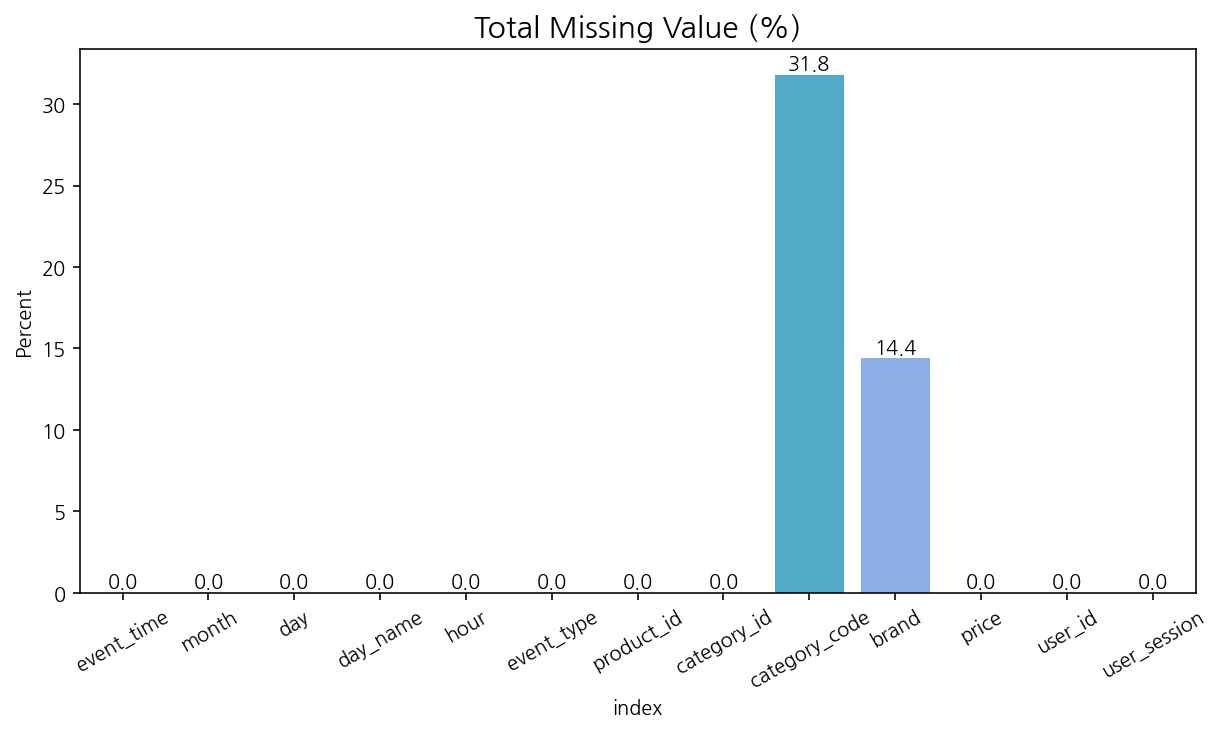

In [ ]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="Percent", data=missing_data.reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

### 결측치 상관관계 확인

#### 걸측치 종류

- 완전 무작위 결측 (MCAR : Missing Completely At Random)

    - 변수 상에서 발생한 결측치가 다른 변수들과 아무런 상관이 없는 경우 완전 무작위 결측이라고 부른다.<br>
    대부분의 결측치 처리 패키지가 MCAR을 가정으로 하고 있고 보통 우리가 생각하는 결측치라고 생각하면 된다.   
    예를 들어, 데이터를 깜박하고 입력 안하거나 전산오류로 누락된 경우이다.   
    이러한 결측치는 보통 제거하거나 데이터 셋에서 단순 무작위 표본추출을 통해 완벽한 데이터셋으로 만들 수 있다.

- 무작위 결측 (MAR : Missing At Random)

    - 결측값이 결측된 변수와는 관련이 없지만 다른변수와는 관련이 있는 경우 무작위 결측이라고 부른다.  
    예를 들어, 여성이 남성보다 체중을 기입하지 않는다. 라고 하면 체중에 결측값이 생기지만,  
    이는 체중 변수와 관련이 있는 것이 아닌 성별 변수와 관련이 있다. 

- 비 무작위 결측 (MNAR : Missing Not At Random)

    - 위 두가지 유형이 아닌 경우 MNAR이라고 하고, 결측값이 결측된 변수와 관련이 있는 경우 비 무작위 결측이라고 한다.  
    예를 들어, 서비스에 불만족한 고객들은 만족도 설문에 응답하지 않는다.  
    
    - 링크 : https://syj9700.tistory.com/10

- 구분 예시

    * 비 무작위 결측 (MNAR)  

        + 우울증이 너무 심한 응답자들이 우울증 문항에 허위 기술을 하거나,  
        정치적, 종교적인 이유로 실제와 전혀 다른 응답하는 경우  
        
        + 위의 예시처럼 설문지 응답에서 중요한 특정 집단이 의도적으로 자신을 감춰버린 상태
    
    * 3번 상태 (NMAR)가 아니라면, 이 결측값 발생이 어느정도 독립적으로 발생하지 않았을까? 라고 생각 가능한 상태가 되고,
    이는 완벽하게 우연히 발생했다면 1번 완전 무작위 결측이 된다 (MCAR)

    * 즉, 결측값의 발생에 뚜렷한 어떤 인과 관계가 숨어있는지 여부로 구분지으면 된다  

    * 링크 : https://gooopy.tistory.com/43  

    * MCAR(Missing Completely At Random)
        
        + 특정 column(c_k)의 결측 여부가 완전히 random으로 발생하는 경우,  

        + 즉 c_k가 다른 c_1, c_2, ...와는 관련이 없을 때를 가리킴

    * MAR(Missing At Random)  

        + 특정 c_k의 결측 여부가 다른 c_1, c_2, ... 중 몇몇과 관련이 있는 경우  

        + 예를 들면, 소득수준(=c_1)에 따라 학업성취도(=c_k)의 결측 여부가 관련이 있을 경우

    * MNAR(Missing Not At Random, non ignorable)  

        + 특정 c_k의 결측 여부가 c_k의 값과 관련이 있는 경우  
        
        + 예를 들면, 학업성취도가 낮은 학생들이 학업성취도에 응답하지 않는 경우

Text(0.5, 1.0, 'Correlation with Missing Values')

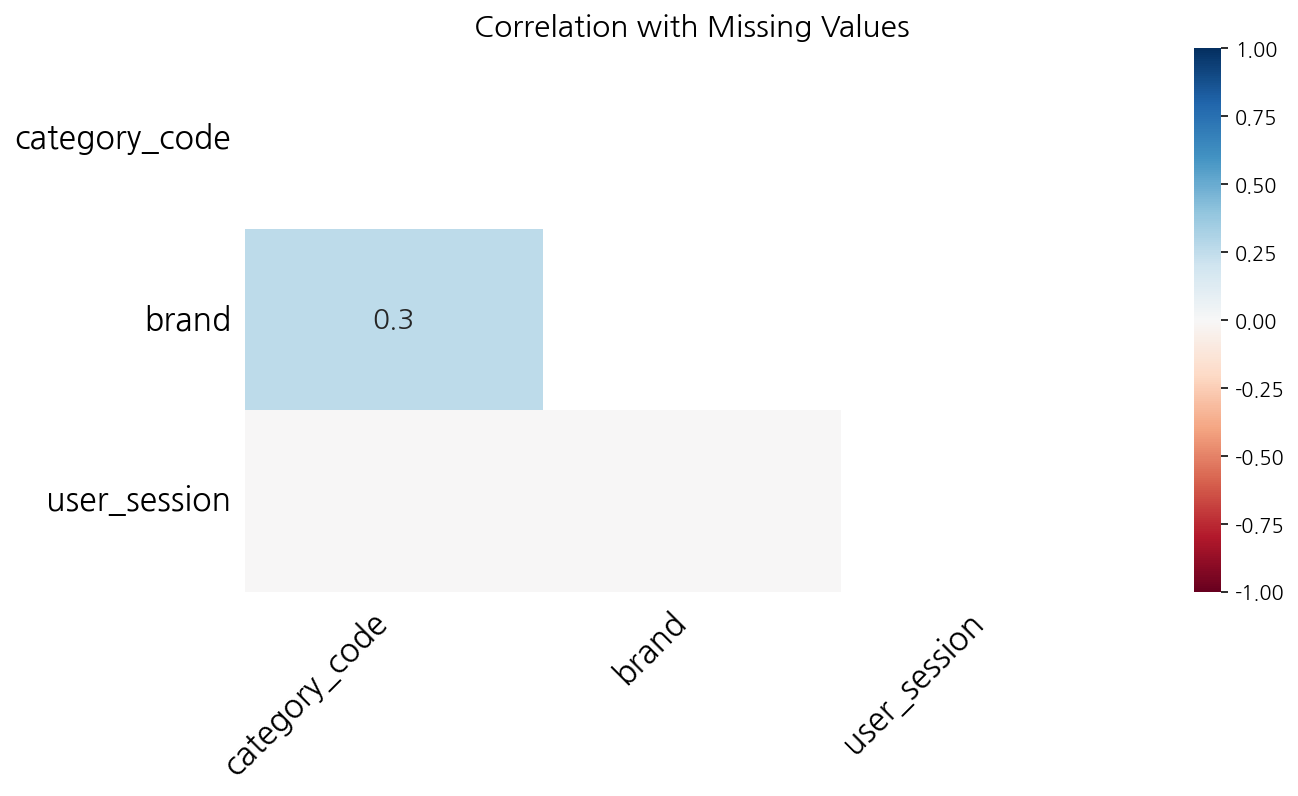

In [ ]:
missingdata_col = mod.columns[mod.isnull().any()].tolist()
msno.heatmap(mod[missingdata_col], figsize=(10, 5))
# msno.heatmap(mod, figsize=(10, 5))
plt.title("Correlation with Missing Values", fontsize=15)

# category_code, brand 상관관계 0.3
# category_code에 결측치가 있으면, brand에 결측치가 존재할 가능성이 어느정도 있다
# -> category_code는 MCAR, brand는 MAR 결측치이다

### 결측치 제거

#### category_code, brand 동시에 결측된 값 제거

In [5]:
# 전체 값 대비 category_code, brand 전부 결측인 값들의 비율
null_cond = (mod["category_code"].isna()) & (mod["brand"].isna())
(mod[null_cond].shape[0] / mod.shape[0]) * 100

8.821333407964483

In [9]:
# 전체 데이터에서 category_code, brand 둘다 NaN 값인 경우 제거
both_null_cond = (mod["category_code"].notna()) | (mod["brand"].notna())
mod[both_null_cond].shape

(38704217, 13)

In [10]:
no_both_null = mod[both_null_cond]
no_both_null.shape

(38704217, 13)

In [ ]:
# 결측치 percent 구함
null_total_2 = no_both_null.isnull().sum()
null_count_2 = no_both_null.isnull().count()
percent_2 = round((null_total_2 / null_count_2) * 100, 1)

# 결측치 개수, 퍼센트 데이터프레임으로 생성
missing_data_2 = pd.concat([null_total_2, percent_2], axis=1, keys=["Total", "Percent"])

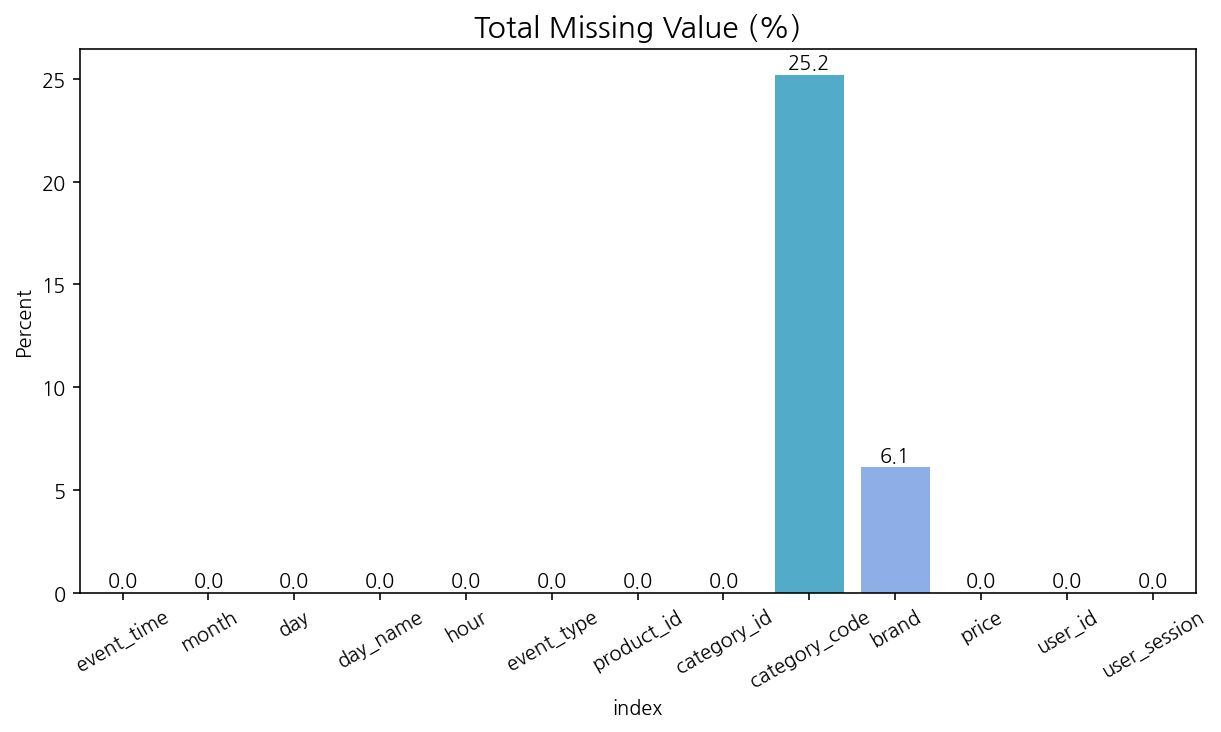

In [ ]:
# 결측치 퍼센트 그래프 생성
plt.figure(figsize=(10, 5))
sns_pct_2 = sns.barplot(x="index", y="Percent", data=missing_data_2.reset_index())
sns_pct_2.set_xticklabels(sns_pct_2.get_xticklabels(), rotation=30)

# bar 그래프 상단에 퍼센트 표기
for bar in sns_pct_2.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.3, "%.1f" % height, ha="center")

sns_pct_2.set_title("Total Missing Value (%)", fontsize=15)
plt.show()

#### 연속형 변수 상관관계

##### 상관관계 테이블 생성 (연속형 변수)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


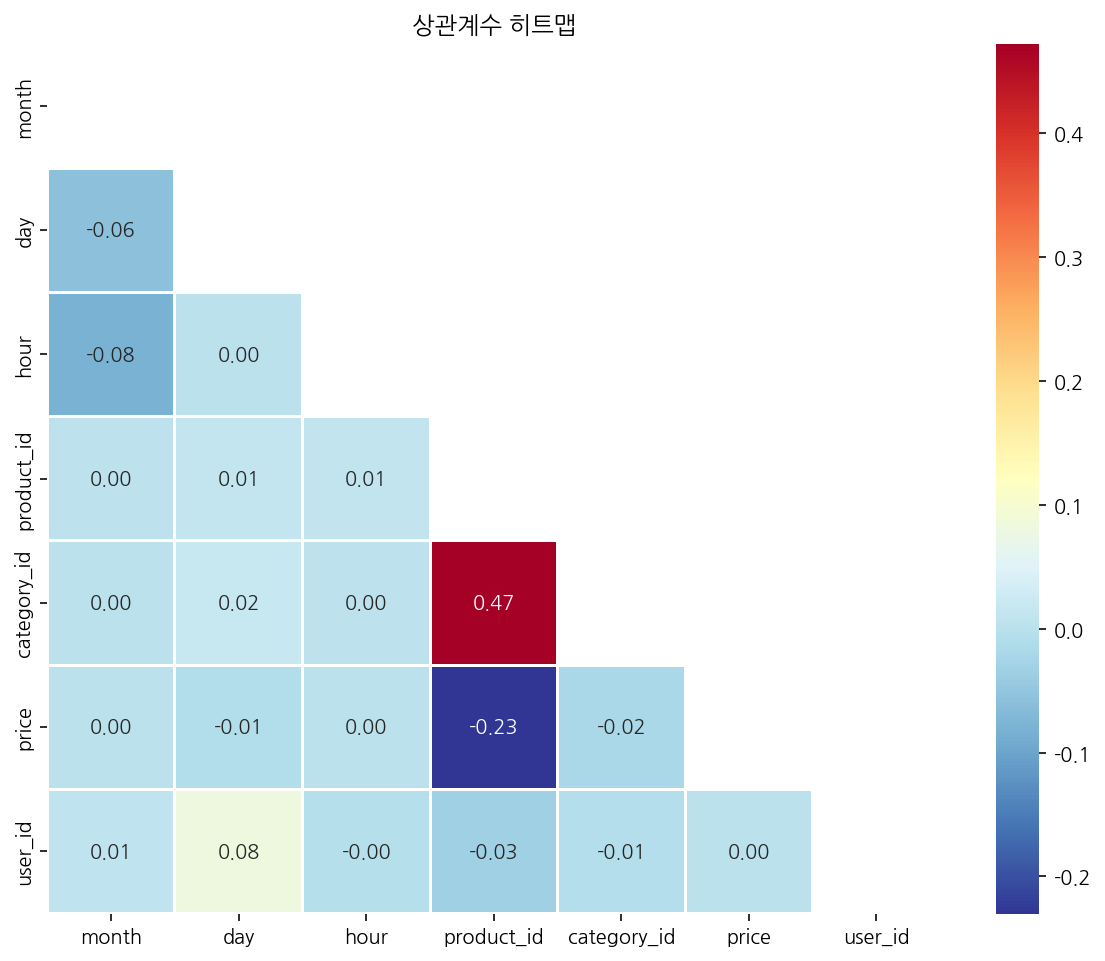

In [ ]:
# 상관계수 테이블
corr = no_both_null.corr()

# 히트맵 사이즈 설정
plt.figure(figsize=(10, 8))

# 히트맵 형태 정의. 여기서는 삼각형 형태 (위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
sns.heatmap(data=corr,          # corr = 상관계수 테이블
            annot=True,         # 히트맵에 값 표시
            mask=mask,          # 히트맵 형태, 여기서는 위에서 정의한 삼각형 형태
            fmt=".2f",          # 값 표시 방식. 소수점 2번째 자리까지
            linewidths=1.,      # 경계면 실선 구분 여부
            cmap="RdYlBu_r")    # 사용할 색 지정 (python colormap 검색)
plt.title("상관계수 히트맵")
plt.show()

# product_id, category_id 상관관계 0.47

In [11]:
no_category = (no_both_null["category_code"].isnull())
null_train = no_both_null[no_category]
# test = no_both_null[no_category]
# train = no_both_null.drop(test.index)

# https://blog.naver.com/PostView.naver?blogId=dalgoon02121&logNo=222482929265&categoryNo=33&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=search

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(no_both_null, test_size=0.3, random_state=42)

In [13]:
train.shape, test.shape

((27092951, 13), (11611266, 13))

In [14]:
train, val = train_test_split(train, test_size=0.3, random_state=42)

In [15]:
train.shape, val.shape, test.shape

((18965065, 13), (8127886, 13), (11611266, 13))

In [20]:
null_train = train[no_category]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [21]:
import datawig

imputer = datawig.SimpleImputer(
    input_columns=['product_id','category_id','price'], # impute에 사용할 컬럼을 지정해줄수 있다. 컬럼 '3'은 제외시켰다.
    output_column= 'category_code', # 컬럼 0의 missing value를 채운다.
    output_path = 'imputer_model_77')

imputer.fit(train_df=train, num_epochs=5)
null_imputed = imputer.predict(null_train)

imputed_train = pd.DataFrame(null_imputed)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
2022-05-16 02:50:50,665 [INFO]  
========== start: fit model
2022-05-16 02:50:50,666 [WARNING]  Already bound, ignoring bind()
2022-05-16 03:01:21,487 [INFO]  Epoch[0] Batch [0-397593]	Speed: 10085.57 samples/sec	cross-entropy=0.246369	category_code-accuracy=0.917037
2022-05-16 03:12:43,548 [INFO]  Epoch[0] Train-cross-entropy=0.187724
2022-05-16 03:12:43,550 [INFO]  Epoch[0] Train-category_code-accuracy=0.936173
2022-05-16 03:12:43,553 [INFO]  Epoch[0] Time cost=1312.882
2022-05-16 03:12:43,558 [INFO]  Saved checkpoint to "imputer_model_77/model-0000.params"
2022-05-16 03:13:30,727 [INFO]  Epoch[0] Validation

In [23]:
# imputed_train 데이터프레임 parquet 파일로 저장
imputed_train.to_parquet("/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/imputed_train.parquet", engine="pyarrow", compression="gzip")

In [25]:
null_val = val[no_category]
null_test = test[no_category]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [26]:
null_imputed_val = imputer.predict(null_val)

imputed_val = pd.DataFrame(null_imputed_val)

In [27]:
null_imputed_test = imputer.predict(null_test)

imputed_test = pd.DataFrame(null_imputed_test)

In [33]:
# imputed_val 데이터프레임 parquet 파일로 저장
imputed_val.to_parquet("/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/imputed_val.parquet", engine="pyarrow", compression="gzip")

In [34]:
# imputed_val 데이터프레임 parquet 파일로 저장
imputed_test.to_parquet("/content/drive/MyDrive/Colab Notebooks/Datasets/cp2_ecommerce/imputed_test.parquet", engine="pyarrow", compression="gzip")

In [28]:
imputed_train.shape, imputed_val.shape, imputed_test.shape

((4785299, 15), (2053770, 15), (2931993, 15))

In [31]:
no_both_null[no_category].shape

(9771062, 13)

In [32]:
imputed_train.shape[0] + imputed_val.shape[0] + imputed_test.shape[0]

9771062

In [35]:
imputed_train.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_imputed,category_code_imputed_proba
37776028,2019-10-28 10:50:15+04:00,10,28,Monday,10,view,26201295,2053013563693335403,None,lucente,106.05,559439102,08239cbc-594f-4216-b1be-7eb7eebf3c18,sport.trainer,0.997836
8697175,2019-10-07 22:07:21+04:00,10,7,Monday,22,view,37900088,2152167773222993940,None,merelani,142.09,521896423,a9cf92aa-3cab-49b4-9210-eaa31ff8280b,furniture.kitchen.table,1.000000
742018,2019-10-01 18:06:05+04:00,10,1,Tuesday,18,view,35000029,2070005009172398851,None,boyscout,1.78,553388118,94512c25-32d1-4310-942b-270d444e2488,apparel.underwear,0.999996
7122008,2019-10-06 17:58:18+04:00,10,6,Sunday,17,view,25510110,2053013562250494749,None,gerat,133.25,550197343,e5f01a1e-adce-4ae9-b961-b0cdf25dcc0c,computers.components.cooler,0.914876
10955526,2019-10-09 16:52:17+04:00,10,9,Wednesday,16,view,12711986,2053013553559896355,None,triangle,37.32,514339370,37b342b6-771f-4786-9f1c-9aacb9003f1b,appliances.kitchen.grill,0.992592


In [40]:
imputed_val.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_imputed,category_code_imputed_proba
29323404,2019-10-22 07:49:17+04:00,10,22,Tuesday,7,view,12718876,2053013553559896355,None,toyo,47.62,547666741,534e977e-57ad-4eae-9326-0cd87304d4b8,appliances.kitchen.grill,0.994776
6514612,2019-10-06 09:38:53+04:00,10,6,Sunday,9,view,29900070,2059484601444729123,None,peda,1171.20,523508207,20293bdc-0e8c-4c66-95b3-0fb9b2b8ec0a,accessories.bag,0.999045
24191524,2019-10-18 17:08:25+04:00,10,18,Friday,17,view,5301399,2053013563173241677,None,elenberg,15.42,513038741,be2fbfc6-c2d2-49e3-a39d-cd47c4babfc6,appliances.environment.air_heater,0.997948
11984959,2019-10-10 12:56:56+04:00,10,10,Thursday,12,view,5301257,2053013563173241677,None,babyliss,77.14,524876399,e18ef0c5-4108-4215-8ec6-7d611af4161a,computers.ebooks,0.999512
21768908,2019-10-16 21:40:27+04:00,10,16,Wednesday,21,view,10800147,2053013554994348409,None,saturn,12.56,527459654,ce3ea971-8361-4251-bf7b-e092f1807f93,appliances.kitchen.mixer,0.997019


In [43]:
imputed_test.head(30)

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_imputed,category_code_imputed_proba
28056349,2019-10-21 09:41:17+04:00,10,21,Monday,9,view,32801128,2055156924273394455,None,riviera,556.44,517666746,225ca51f-4efc-4223-9a85-e5d9e2e9852d,sport.trainer,0.852145
3425387,2019-10-03 22:08:50+04:00,10,3,Thursday,22,view,18000919,2053013558525952589,None,samsung,18.79,554913410,dd7b1192-2638-4082-8b0f-bd18fc070610,computers.desktop,0.788474
1109765,2019-10-01 22:14:36+04:00,10,1,Tuesday,22,view,31500151,2053013558031024687,None,luminarc,36.00,551370781,7ccd4e9b-f9fe-4667-ae18-574697d4642c,computers.components.cooler,0.999465
19415266,2019-10-15 12:53:52+04:00,10,15,Tuesday,12,cart,3300315,2053013555355058573,None,redmond,95.21,524487175,e16e71b7-3694-4cd1-9609-ad4bb90dd75d,appliances.kitchen.meat_grinder,0.987186
20944284,2019-10-16 12:47:54+04:00,10,16,Wednesday,12,view,4100346,2053013561218695907,None,sony,390.81,552358521,b7c59cb8-d620-48b9-8934-87f97c725a37,appliances.environment.air_conditioner,0.979219
39047427,2019-10-29 10:59:57+04:00,10,29,Tuesday,10,view,12703498,2053013553559896355,None,cordiant,40.93,514581316,ac2208fb-f051-4a3a-8e11-1c1c7297c2ec,appliances.kitchen.grill,0.993384
9521192,2019-10-08 15:58:04+04:00,10,8,Tuesday,15,view,12719961,2053013553559896355,None,kapsen,49.68,558022069,37e66797-7d53-423f-9977-485b845f7d72,appliances.kitchen.grill,0.995128
2800252,2019-10-03 12:44:20+04:00,10,3,Thursday,12,view,12701082,2053013553559896355,None,pirelli,123.17,521809752,276f883d-4a99-4fff-a147-9cc1d9212b75,appliances.kitchen.grill,0.996913
1644493,2019-10-02 12:39:50+04:00,10,2,Wednesday,12,view,12703015,2053013553559896355,None,cordiant,42.99,517513400,1c89afac-9305-47bc-8522-b907f5acbb33,appliances.kitchen.grill,0.993820
39404411,2019-10-29 16:41:16+04:00,10,29,Tuesday,16,view,10501366,2053013553199186187,None,edufun,97.79,515811590,df6764af-fd13-4976-8ace-f7d418206a73,kids.toys,0.946752


In [ ]:
# 전체 값 대비 brand가 lucente인 것의 비율
lucente_cond = (mod["brand"] == "lucente")
(mod[lucente_cond].shape[0] / mod.shape[0]) * 100

In [ ]:
# category_code, brand 둘 중 하나라도 결측치가 있는 데이터
cond = (mod["category_code"].isna()) | (mod["brand"].isna())
mod[cond]["brand"].value_counts().head(20)

In [ ]:
lucente = (mod["brand"] == "lucente")
# mod[lucente]["category_code"].value_counts()
mod[lucente]["price"].value_counts().sort_index(ascending=False)

In [ ]:
mod[lucente]

In [ ]:
xiao = (mod["brand"] == "xiaomi")
xiao_none = (mod["brand"] == "xiaomi") & (mod["category_code"].isna())
mod[xiao_none]["price"].value_counts().head(30)

In [ ]:
xiao_20 = (mod["brand"] == "xiaomi") & (mod["price"] >= 20) & (mod["price"] < 30)
mod[xiao_20]["category_code"].value_counts()

In [ ]:
xiao_75 = (mod["brand"] == "xiaomi") & (mod["price"] >= 75) & (mod["price"] < 80)
mod[xiao_75]["category_code"].value_counts()

In [ ]:
xiao_70 = (mod["brand"] == "xiaomi") & (mod["price"] >= 70) & (mod["price"] < 75)
mod[xiao_70]["category_code"].value_counts()

In [ ]:
mod[xiao_70]["price"].sort_values(ascending=False)

In [ ]:
# event_time 월만 빼내기
df["event_time"].dt.month

In [ ]:
# event_time 일만 빼내기
df["event_time"].dt.day

In [ ]:
# event_time 시간만 빼내기
df["event_time"].dt.hour

In [ ]:
# event_time 분만 빼내기
df["event_time"].dt.minute

In [ ]:
# event_time 요일 이름만 빼내기
df["event_time"].apply(lambda x : x.day_name())

In [ ]:
1+10

In [ ]:
df["category_code"].str.split(".").str[0]